# 2019 2nd ML month with KaKR
[캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)
- 참고자료
  - [25th solution (XGB + LightGBM Ensemble)](https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble)
  - [Geo Data EDA And Feature Engineering](https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering#Geo-Data-EDA-&-Feature-Engineering)

# matplotlib 시각화를 위한 셀

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 여러가지 Library Import

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn import neighbors
import xgboost as xgb
import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns

# 분석 기본 도구
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


#  데이터 불러오기

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

[Target] 
- price : 타겟 변수인 집의 가격

[Data]
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. **sqft_living** : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. **waterfront** : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. **condition** : 집의 전반적인 상태
12. **grade** : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
!ls ../input/d/cookierhkwk/2019-2nd-ml-month-with-kakr

test.csv  train.csv


In [51]:
dir_path = '../input/d/cookierhkwk/2019-2nd-ml-month-with-kakr'
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv')
# sub_data_path = join(dir_path, 'sample_submission.csv')

- [Trouble] 우측 Data창에는 분명 ../input/2019-2nd-ml-month-with-kakr/test.csv이 파일경로인데, ls로 살펴보면 ../input에 csv파일이 저장되어 있음
  - 왜 ?

In [88]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
# sub = pd.read_csv(sub_data_path)

print(f'train data dim : {train.shape}')
print(f'sub data dim : {test.shape}')
# print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


- 참고자료
  - [del keyword](https://www.w3schools.com/python/ref_keyword_del.asp)
  - [DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

- 학습 데이터에서 라벨 제거: `price` 컬럼은 따로 `y`라는 변수에 저장한 후 해당 컬럼은 지워줍니다.

In [89]:
train_y = train['price']
del train['price']

- 학습 데이터와 테스트 데이터 합치기
  - 전체 데이터에 대해 탐색해보기 위해 두 데이터를 `pd.concat`
  - 데이터를 합치기 전 `train_len`에 `training data`의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용

In [90]:
#★
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [91]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 with LIBRARY: missingno
### 결측치
#### 확인
`missingno` 라이브러리의 `matrix` 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

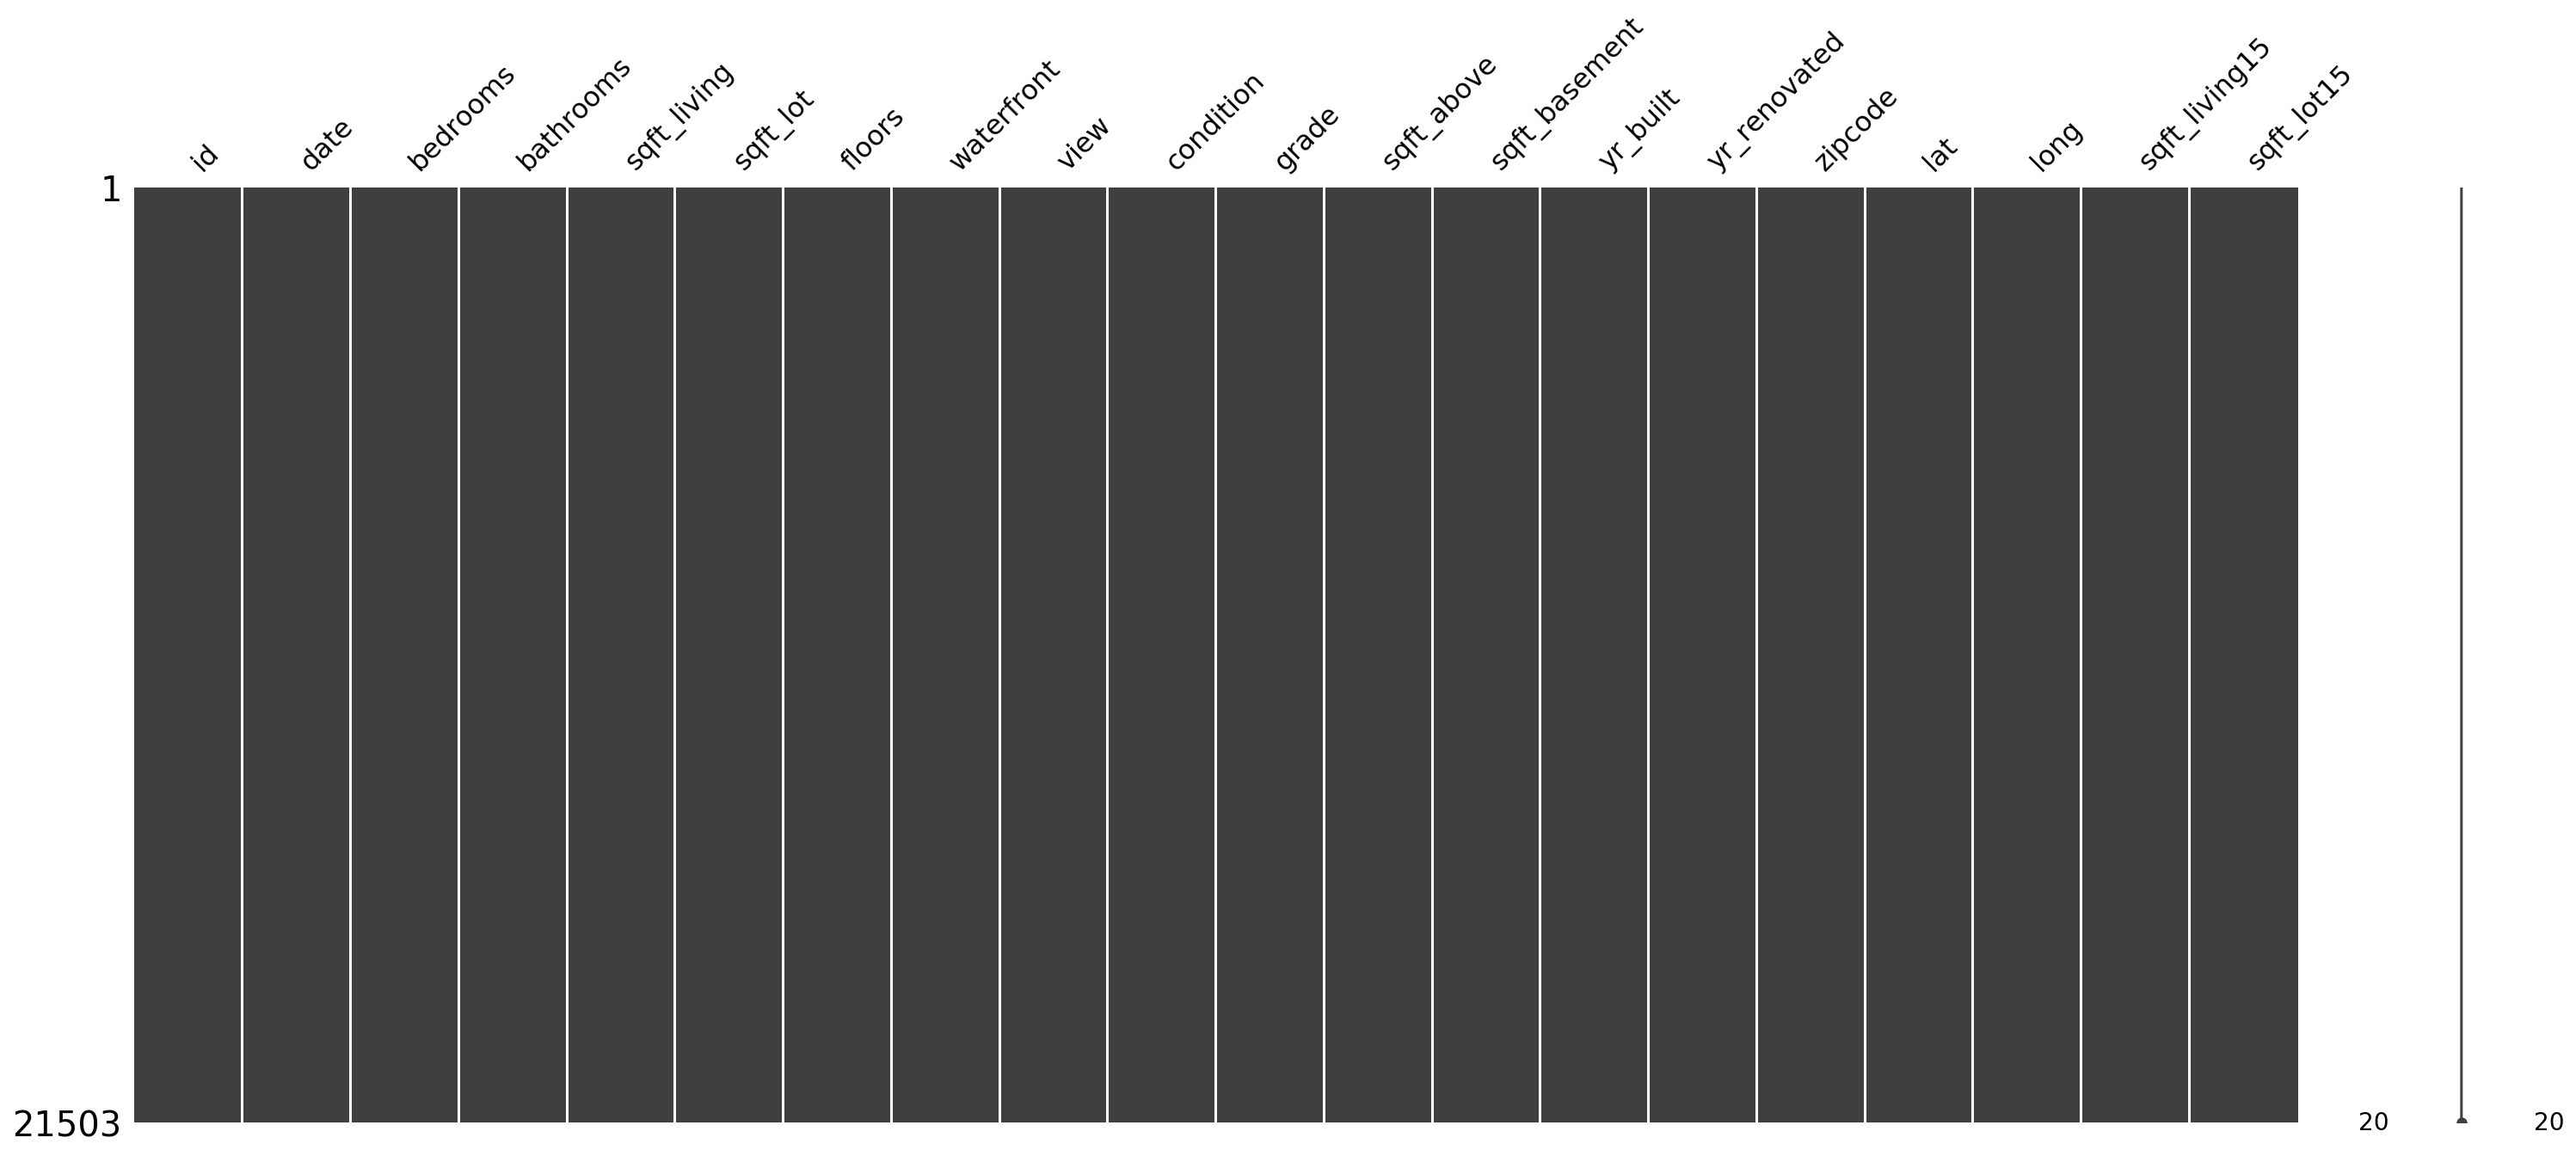

In [92]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [93]:
for c in data.columns:
#     print(f'{c} : { len( data.loc[ data[c].isnull(), c].values ) }')
    print(f'{c} : {data[c].isnull().sum()}')

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


# 🕵️‍♂️변수 처리

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

 - 참고자료: [Pandas Lambda, apply를 활용하여 복잡한 로직 적용하기](https://data-newbie.tistory.com/207)

In [94]:
#test data에서는 입력으로 쓰임! 남기기!
test_id = data['id'][train_len:]
del data['id']

In [95]:
len(test_id)

6468

In [96]:
data['date'] = data['date'].map(lambda x : str(x[:6]))
data['date'] = pd.to_datetime(data['date'], format='%Y%m')
data['year'] = data['date'].dt.year # int형
data['month'] = data['date'].dt.month # int형
# data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
del data['date']

### 각 변수들의 분포 확인 및 변수변환
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [82]:
print(data.columns)
len(data.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')


21

## X의 분포

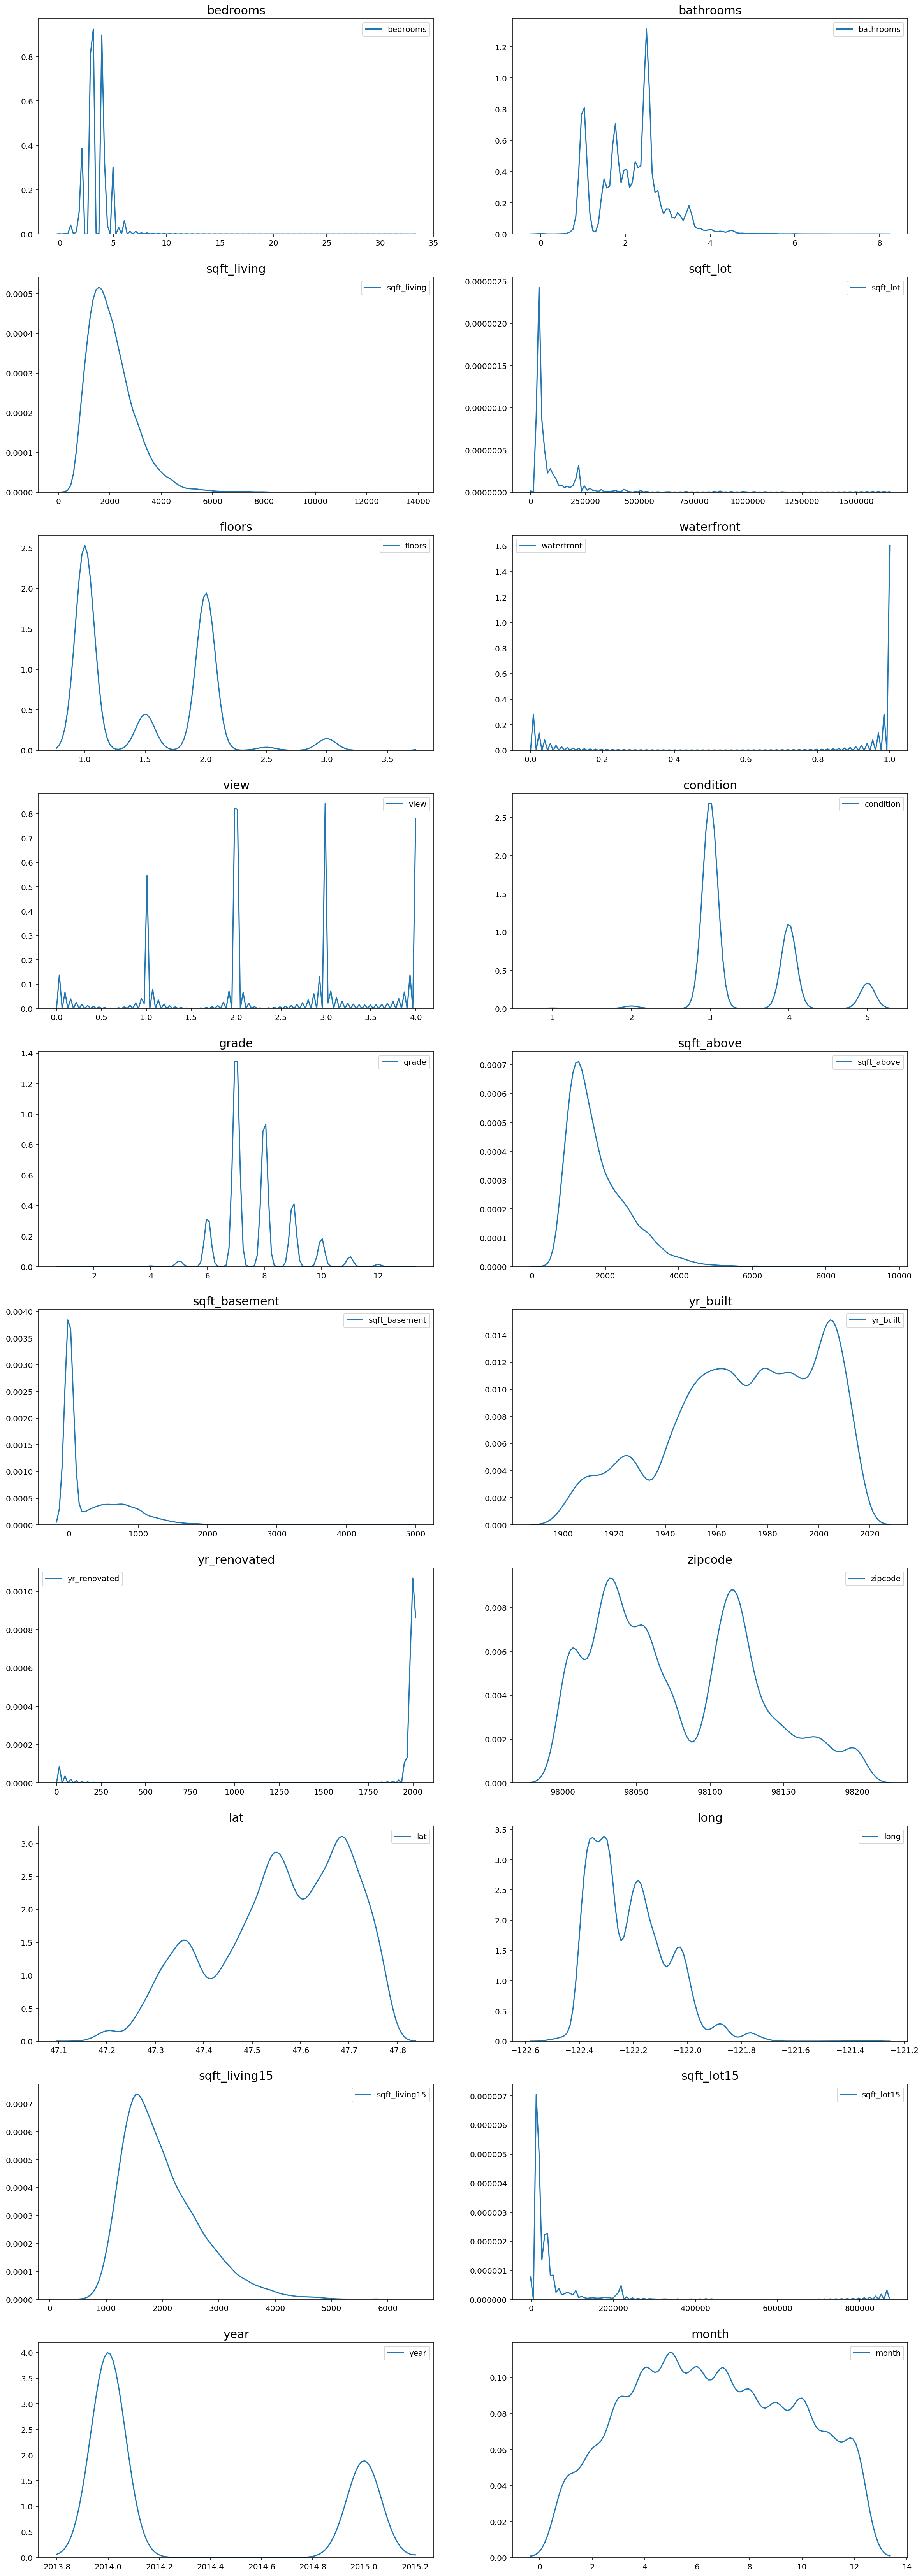

In [62]:
fig, axes = plt.subplots(10, 2, figsize = ( 20, 60))

# id 변수는 제외하고 분포를 확인합니다.

columns = data.columns
for idx, ax in enumerate(axes.flatten(), 1):
    if idx == len(columns) :
        break
    sns.kdeplot(data[columns[idx]], ax = ax)
    ax.set_title(columns[idx], fontsize = 15)
    
# count = 0
# for row in range(11):
#     for col in range(2):
#         sns.kdeplot(data[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count+=1
#         if count == 19 :
#             break

## y의 분포

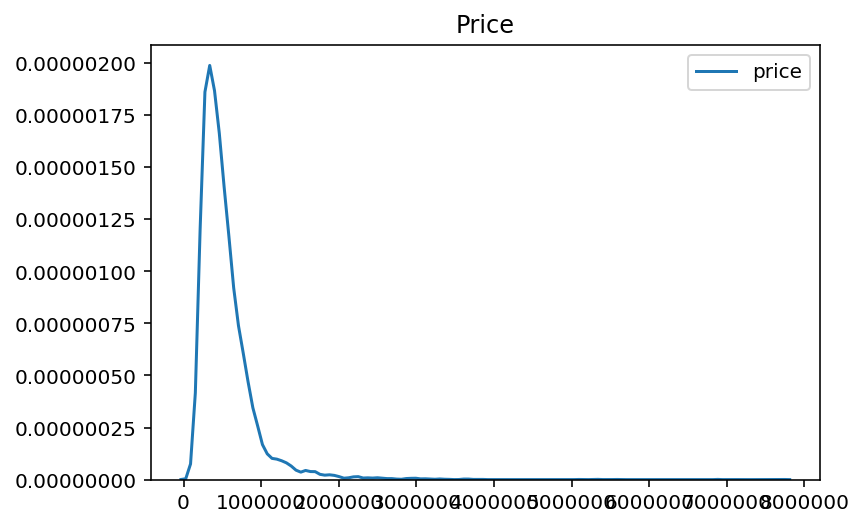

In [63]:
sns.kdeplot(train_y)
plt.title('Price')
plt.show()

- `price`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement` 변수가 한쪽으로 치우친 경향
  - `bedrooms` 은 안치우쳤는데 왜 치우쳤다고 한거지 ?
- log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

- `numpy.log1p()` 함수는 입력 배열의 각 요소에 대해 자연로그 `log(1 + x)`을 반환해 주는 함수
  - 자료의 범위가 >= 0 일 경우에 음수값이 없도록 만들어 주는 로그변환!

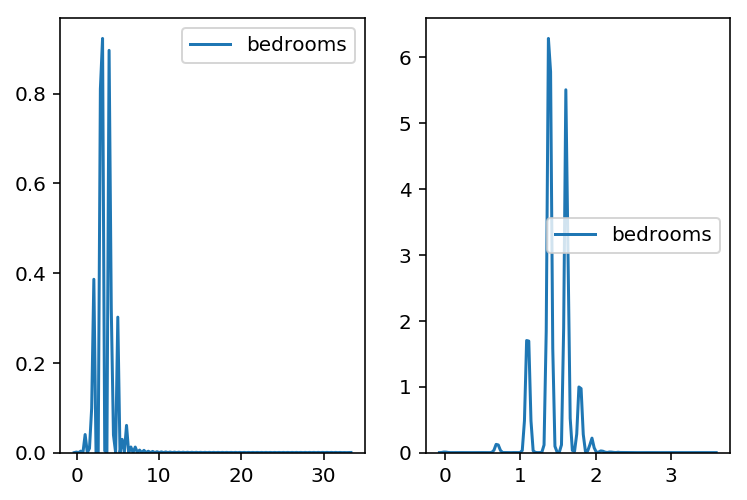

In [64]:
#temp: 딱히 기울어진 것도, 기울어진게 개선되지도 않음
temp = data['bedrooms']
temp_log = np.log1p(data['bedrooms'])

fig, axes = plt.subplots(1,2)
sns.kdeplot(temp, ax = axes[0])
sns.kdeplot(temp_log, ax = axes[1])

## 변수변환 of train_X, train_y
 - 성능향상을 위해 수행해주지 않음
 - [Trouble] 왜 log1p를 수행하지 않으면 Score가 좋아질까 ?
   - log 변환이 왜 필요했는지에 대한 이유를 먼저 고민해 봐야 한다.
   - 회귀분석의 입력변수의 skewness를 줄이려는 이유가 뭘까? 아직 알지 못한다.

In [65]:
# skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# for c in skew_columns:
#     data[c] = np.log1p(data[c].values)

In [19]:
# train_y = np.log1p(train_y)
# sns.kdeplot(train_y)
# plt.show()

변환 후 확인: 어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

- 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까?
  - log는 0 ~ 1 사이의 값은 펼쳐주고, 아주 큰 값은 모아준다!
    - 0 ~ 1 사이에 값이 많아서 왼쪽으로 치우친 분포는 치우침이 줄어들게 된다
    - 아주 큰 값에 값이 많아서 skewed to right분포는 꼬리가 줄어들게 된다

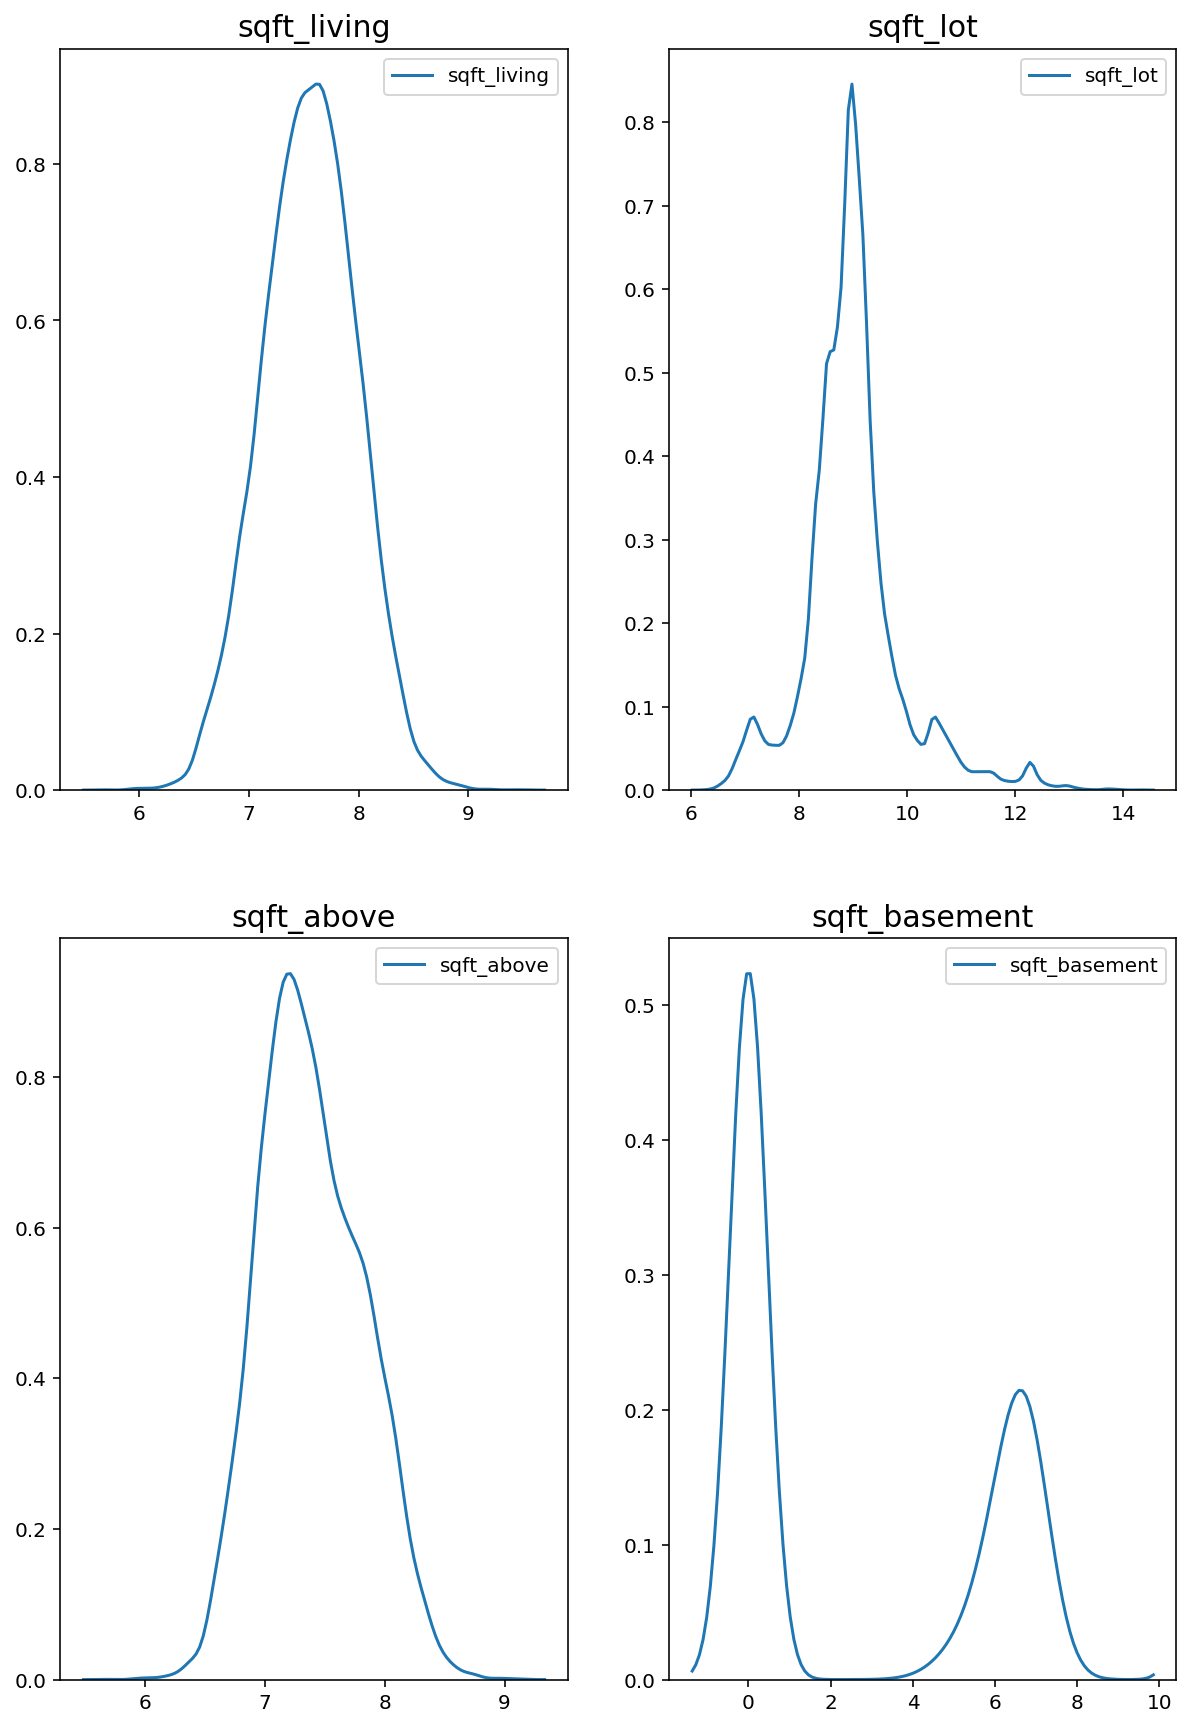

In [20]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 15))

# for idx, ax in enumerate(axes.flatten()):
#     if idx == len(skew_columns):
#             break
#     sns.kdeplot(data[skew_columns[idx]], ax=ax)
#     ax.set_title(skew_columns[idx], fontsize=15)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 21 columns):
date             21503 non-null datetime64[ns]
bedrooms         21503 non-null int64
bathrooms        21503 non-null float64
sqft_living      21503 non-null float64
sqft_lot         21503 non-null float64
floors           21503 non-null float64
waterfront       21503 non-null int64
view             21503 non-null int64
condition        21503 non-null int64
grade            21503 non-null int64
sqft_above       21503 non-null float64
sqft_basement    21503 non-null float64
yr_built         21503 non-null int64
yr_renovated     21503 non-null int64
zipcode          21503 non-null int64
lat              21503 non-null float64
long             21503 non-null float64
sqft_living15    21503 non-null int64
sqft_lot15       21503 non-null int64
year             21503 non-null int64
month            21503 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(12)
memory usage: 3.6 MB

## 기타 특성 공학

In [23]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')

In [97]:
data['zip_1'] = data['zipcode'].apply(lambda x : str(x)[2]).astype(int)
data['zip_12'] = data['zipcode'].apply(lambda x : str(x)[2:4]).astype(int)
data['zip_2'] = data['zipcode'].apply(lambda x : str(x)[3]).astype(int)
data['zip_23'] = data['zipcode'].apply(lambda x : str(x)[3:5]).astype(int)
data['zip_3'] = data['zipcode'].apply(lambda x : str(x)[4]).astype(int)

le = LabelEncoder()
le.fit(data['zipcode'])

data['zipcode'] = le.transform(data['zipcode'])

In [98]:
data['sqft_total_size'] = data['sqft_above'] + data['sqft_basement'] # 총 주거 면적    

In [99]:
train_X = data.iloc[:train_len, :]
test_X = data.iloc[train_len:, :]

 - 주변 시세를 고려해보자!

In [100]:
####### zipcode_groupby 단가 변수 생성
train_X['price_per_land_area'] = train_y / (train_X['sqft_living'])
price_per_ft = train_X.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()
train_X = pd.merge(train_X, price_per_ft, how='left', on='zipcode')
test_X = pd.merge(test_X, price_per_ft, how='left', on='zipcode')
del train_X['price_per_land_area']

In [70]:
# train_y = np.log1p(train_y)

In [87]:
print(train_X.info())
print(train_X.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 30 columns):
id                 15035 non-null int64
bedrooms           15035 non-null int64
bathrooms          15035 non-null float64
sqft_living        15035 non-null int64
sqft_lot           15035 non-null int64
floors             15035 non-null float64
waterfront         15035 non-null int64
view               15035 non-null int64
condition          15035 non-null int64
grade              15035 non-null int64
sqft_above         15035 non-null int64
sqft_basement      15035 non-null int64
yr_built           15035 non-null int64
yr_renovated       15035 non-null int64
zipcode            15035 non-null int64
lat                15035 non-null float64
long               15035 non-null float64
sqft_living15      15035 non-null int64
sqft_lot15         15035 non-null int64
year               15035 non-null int64
month              15035 non-null int64
zip_1              15035 non-null int64
zip

# 학습용 데이터 생성: train(x), test

In [101]:
train_X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_1', 'zip_12',
       'zip_2', 'zip_23', 'zip_3', 'sqft_total_size', 'count', 'mean', 'std'],
      dtype='object')

In [102]:
# data = x['date']
train_X = train_X[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_1', 'zip_12',
       'zip_2', 'zip_23', 'zip_3', 'sqft_total_size', 'count', 'mean', 'std']]
test_X = test_X[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_1', 'zip_12',
       'zip_2', 'zip_23', 'zip_3', 'sqft_total_size', 'count', 'mean', 'std']]

# 📘 BASELINE 설정편

## 1. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.
- Ensemble, Blending 모델
  - Voting: 다수결 투표, 분류문제
  - Averaging, Bagging: 산술/가중 평균, 회귀문제
- 참고자료
  - [수비니움-Part 1. Introduction to Ensemble Learning](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4)
  - [kaggle ensemble guide[한]](https://gentlej90.tistory.com/73)
    - 왜 여러개의 모델이 더 좋은가 ? X ~ B(n, p = 0.7)를 떠올려보자!
  - [kaggle ensemble guide[영]](https://mlwave.com/kaggle-ensembling-guide/?lipi=urn%3Ali%3Apage%3Ad_flagship3_pulse_read%3BPZ4T3JLHTu%2BOWNI0d5kFbg%3D%3D)

### Boosting 모델의 Blending

In [32]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
#★사용할 모델과 모델명을 가진 딕셔너리의 리스트!!
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

- def cross_val_score(...)
  - Returns R² when model is Regression
  - 참고자료: [결정계수 R²](https://newsight.tistory.com/259)

In [33]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train_X.values)
    for m in models:
        print(f"Model {m['name']} \
        CV score : {np.mean(cross_val_score(m['model'], train_X.values, train_y, cv = kfold)):.4f}")

In [34]:
get_cv_score(models)

Model GradientBoosting         CV score : 0.8900
Model XGBoost         CV score : 0.8895
Model LightGBM         CV score : 0.9036


### Make Submission

In [35]:
def AveragingBlending(models, train_X, train_y, test_X):
    for m in models : 
        m['model'].fit(train_X.values, train_y)
    
    predictions = np.column_stack([m['model'].predict(test_X.values) for m in models])
    return np.mean(predictions, axis=1)

In [36]:
y_pred = AveragingBlending(models, train_X, train_y, test_X)

- [Trouble] Kaggle 오류 데이터
  - Kaggle 상에 올라와 있는 data는 test와 submission_sample의 id가 서로 다른 데이터이다. 향후 test와 sample_submission의 sanity check의 필요성을 느낌
    - train id : 0 ~ 15034
    - sample_submission : 15035 ~ 21502
    - test id : 15208 ~ 21762
  - LMS의 데이터를 Kaggle에서 다시 검색해 [옳은 자료](https://www.kaggle.com/cookierhkwk/2019-2nd-ml-month-with-kakr?select=test.csv)를 찾았음

In [37]:
# sub = pd.DataFrame(data={'id':test_id,'price':y_pred})

# sub.columns

#sub = pd.merge(sub[['id']], test, how = 'left', on = 'id')

# sub.to_csv('submission.csv', index=False)z

# 베이스라인을 설정하였다.
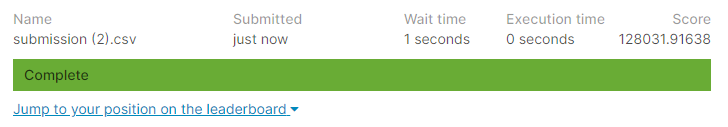

# 📕 실전편 
## 👨‍🏫성능을 개선해보자!

- 성능향상 요건
  - EDA
  - 다양한 모델 시도하기(LGBMRegressor, XGBRegressor, RandomForestRegressor, ... )
  - 파인 튜닝
    - lightgbm
      - `max_depth` : 의사 결정 나무의 깊이, 정수 사용
      - `learning_rate` : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
      - `n_estimators` : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
      - `num_leaves` : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
      - `boosting_type` : 부스팅 방식, gbdt, rf 등의 문자열 입력
     - 참고자료: [[Chapter 4. 분류] LightGBM](https://injo.tistory.com/48), [lightGBM/XGBoost 파라미터 설명](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)
  - Blending

In [38]:
#전처리 및 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#하이퍼 파리미터 튜너
from sklearn.model_selection import GridSearchCV


In [39]:
#평가 시 원래의 형태로 변환 후 계산해야 함
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
#     return np.sqrt(mean_squared_error(y_test, y_pred))

- Topic: 모델과 random_state
  - 파라미터 초기화나 데이터셋 구성 양상을 결정하는 요인으로, 고정해주지 않으면 머신러닝 학습결과가 매번 달라지게 된다.

# Grid Search

- 참고자료
  - Scoring: [사이킷런 Scoring Parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [41]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    # where RMSLE는 주어진 y를 log변환하여 구한 RMSE값
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [42]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20]
}

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# for model in models :
#     print(model.__class__.__name__)
#     print(my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5))

# #Forest는 learning rate가 없고,
# # GBR : 0.1 10 100
# # XGB : 0.1 10 200
# # LGB : 0.1 20 300 이 가장 높음

- 각 모델별로 다음 파라미터가 높은 성능을 냄을 알 수 있었다.
  - Forest는 learning rate가 없고,
  - GBR : 0.1 10 100
  - XGB : 0.1 10 200
  - LGB : 0.1 20 300 이 가장 높음

# 제출할 모델 수행

In [106]:
gboost = GradientBoostingRegressor(learning_rate = 0.1 ,max_depth = 10,n_estimators = 100,  random_state=random_state)
xgboost = XGBRegressor(learning_rate = 0.1, max_depth = 10,n_estimators = 200,random_state=random_state)
lightgbm = LGBMRegressor(learning_rate = 0.1, max_depth = 20,n_estimators = 300,random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
# neighbors = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

gboost.fit(train_X, train_y)
xgboost.fit(train_X, train_y)
lightgbm.fit(train_X, train_y)
# rdforest.fit(train_X, train_y)
# neighbors.fit(train_X, train_y)

# pred_gb = np.expm1(gboost.predict(test_X))
# pred_xgb = np.expm1(xgboost.predict(test_X))
# pred_lgb = np.expm1(lightgbm.predict(test_X))

pred_gb = gboost.predict(test_X)
pred_xgb = xgboost.predict(test_X)
pred_lgb = lightgbm.predict(test_X)
# pred_rdf = np.expm1(rdforest.predict(test_X))
# pred_nei = np.expm1(neighbors.predict(test_X))

In [107]:
# prediction = np.mean(np.column_stack([pred_gb, pred_xgb, pred_lgb]), axis = 1 )
prediction = 0.125*pred_gb + 0.5*pred_xgb + 0.375*pred_lgb

# model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
# model_name = model.__class__.__name__
# model.fit(x, y)
# prediction = np.expm1(model.predict(test))
# prediction

In [108]:
sub = pd.DataFrame(data = {'id':test_id, 'price':prediction})
sub.to_csv('./submission.csv', index = False)

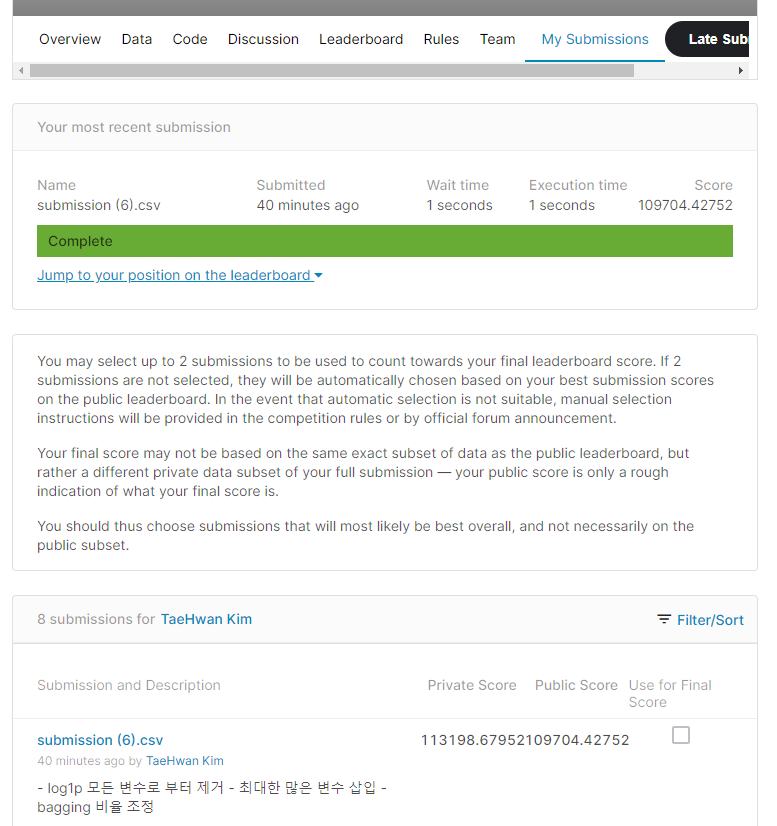

- **루브릭 기준**을 충족하였다!
  - 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
  - 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
  - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

# 회고
 - 해커톤에 이어진 캐글 노드로 데이터 분석을 연습하기 적합한 과제였다.
 - 머신러닝을 진행함에 있어서 다양한 성능향상 요건이 있음을 알게 되었고, 모방을 통해 특성공학과 파인튜닝에 대한 여러가지 시도를 해 볼 수 있었다.
 
 - 하지만 데이터에 대한 직관적인 이해 없이 수치적으로만 접근하고, 스코어에만 연연해 결과를 획득했다.
   - 예를 들어, 부동산의 가격을 예측한다면 가장 1순위는 주변지역의 시세일 것이다.(공시지가도 이와같이 책정한다) 당연히 평당 단가를 변환하는 분석을 하였어야 하나 다른 커널을 참고 하기 전까지는 떠올리지 못하였다. 그리고 이어지는 순위에 위치, 뷰(한강 뷰, 바다 뷰), 집의 크기 등이 있을 것이다. 이처럼 데이터에 대한 상식적인 이해를 토대로 분석해야 함을 느꼈다.
 - 또한 데이터를 모델에 학습시킬때 내부적으로 이루어지는 행위에 대한 이해가 부족한 채 과제를 진행했다. 기본적인 다항 회귀분석을 생각해보면, 너무 많은 변수의 입력은 **다중공선성** 문제로 **조건수**의 크기를 키울 가능성이 있다. 따라서 불필요한 변수를 삭제하는 과정이 필요하다. 그런데 이 과제를 진행하면서 이러한 고려 없이 최대한 많은 변수를 넣어 성능을 높혔다. 다행히 test 데이터를 잘 설명했으나, 일반적으로 과적합으로 인해 test데이터를 잘 설명하지 못할 가능성이 큰 방식이었다. 
 - 위의 데이터에 대한 상식적인 이해와 모델의 학습방식을 이해하고 적용하기 위해 데이터에 대한 다양한 접근과 모델의 체계적인 학습이 필요함을 또 한번 절실히 느꼈다.
   > - 부동산 문제가 나오면, 부동산에 대한 상식을 갖고 접근하자.
   > - **회귀분석**을 먼저 공부하자. 선형대수학에서 **조건수**에 대해 공부하자. 
 - 이런식으로 필요성을 느끼는 것이 학습에 대한 또 다른 동기가 되는 것이 즐겁다.
